In [2]:
from typing import List, Union
from functools import partial

import numpy as np
import pandas as pd
from tqdm import tqdm
from math import sqrt

from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest

from survlimepy.load_datasets import RandomSurvivalData

import scipy as sp

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances

w_path = '/home/carlos.hernandez/PhD/survlime-paper/survLime/computed_weights_csv/exp1/'

In [21]:
def compare_survival_times(bb_model : Union[CoxPHSurvivalAnalysis, RandomSurvivalForest],
                           coefs : np.ndarray,
                           X_train : pd.DataFrame, y_train : np.ndarray, X_test : pd.DataFrame, true_coef : List[float] = None):

    times_train = [x[1] for x in y_train]
    times_to_fill = list(set(times_train)); times_to_fill.sort()
    
    model_interpretable = CoxPHSurvivalAnalysis(alpha=0.0001)
    model_interpretable.fit(X_train, y_train)
    model_interpretable.coef_ = coefs
    # Obtain the predictions from both models
    preds_bb      = bb_model.predict_survival_function(X_test)
    preds_survlime = model_interpretable.predict_survival_function(X_test)

   
    # We need to do this to have the same size as the cox output
    if isinstance(bb_model, RandomSurvivalForest):
        preds_bb_y  = np.mean([fill_matrix_with_total_times(times_to_fill, x.y, list(x.x)) for x in preds_bb], axis=0)
    else:
        preds_bb_y  = np.mean([x.y for x in preds_bb], axis=0)

    preds_surv_y = np.mean([x.y for x in preds_survlime], axis=0)

    rmse = sqrt(mean_squared_error(preds_bb_y, preds_surv_y))
    if isinstance(bb_model, CoxPHSurvivalAnalysis):
        plot_num=2
        
        if true_coef:
            data  =  [bb_model.coef_, coefs, true_coef]
            index =  ['CoxPH', 'SurvLIME', 'True coef']
        else:
            data  = [bb_model.coef_, coefs]
            index = ['CoxPH','SurvLIME']
        df = pd.DataFrame(columns=bb_model.feature_names_in_, 
                  data=data, index=index)

        # Create axes and access them through the returned array
        fig, axs = plt.subplots(1, plot_num, figsize=(15,5))
        df.transpose().plot.bar(ax=axs[0])
        axs[0].set_title('Coefficient values for bb model and survlime')
        axs[1].step(preds_bb[0].x, preds_bb_y, where="post", label='BB model')
        axs[1].step(preds_survlime[0].x, preds_surv_y, where="post", label='SurvLIME')
        axs[1].legend()
        axs[1].set_title(f'Mean survival time comparison RMSE: {rmse:.3}')
    # If we are using other model, we don't have coefficients to compare with
    else:
        plt.step(preds_survlime[0].x, preds_bb_y, where="post", label='BB model')
        plt.step(preds_survlime[0].x, preds_surv_y, where="post", label='SurvLIME')
        plt.legend()
        plt.title(f'Mean survival time comparison RMSE: {rmse:.3}')

def create_clusters():
    """
    Creates the clusters proposed in the paper: https://arxiv.org/pdf/2003.08371.pdf
    Returns:
    cluster 0: list[Data, target]
    cluster 1: List[Data, target]
    """
    
    # These values are shared among both clusters
    radius = 8
    num_points = 1000
    prob_event = 0.9
    lambda_weibull = 10**(-6)
    v_weibull = 2
  
    # First cluster
    center = [0, 0, 0, 0, 0]
    coefficients = [10**(-6), 0.1,  -0.15, 10**(-6), 10**(-6)]
    rds = RandomSurvivalData(center, radius, coefficients, prob_event, lambda_weibull, v_weibull, random_seed=23)
    X_0, T_0, delta_0 = rds.random_survival_data(num_points)
    z_0 = [(d, int(t)) for d, t in zip(delta_0, T_0)]
    y_0 = np.array(z_0, dtype=[('delta', np.bool_), ('time_to_event', np.float32)])
    
    # From page 6 of the paper (I think)
    center = [4, -8, 2, 4, 2]
    coefficients = [10**(-6), -0.15, 10**(-6), 10**(-6), -0.1]
    rds = RandomSurvivalData(center, radius, coefficients, prob_event, lambda_weibull, v_weibull, random_seed=23)
    X_1, T_1, delta_1 = rds.random_survival_data(num_points)
    z_1 = [(d, int(t)) for d, t in zip(delta_1, T_1)]
    y_1 = np.array(z_1, dtype=[('delta', np.bool_), ('time_to_event', np.float32)])

    return [X_0, y_0], [X_1, y_1]

In [22]:
 # Experiment 1.1
cluster_0, cluster_1 = create_clusters()
x_train_0, x_test_0, y_train_0, y_test_0 = train_test_split(cluster_0[0], cluster_0[1], test_size=0.1, random_state=10)
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(cluster_1[0], cluster_1[1], test_size=0.1, random_state=10)

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


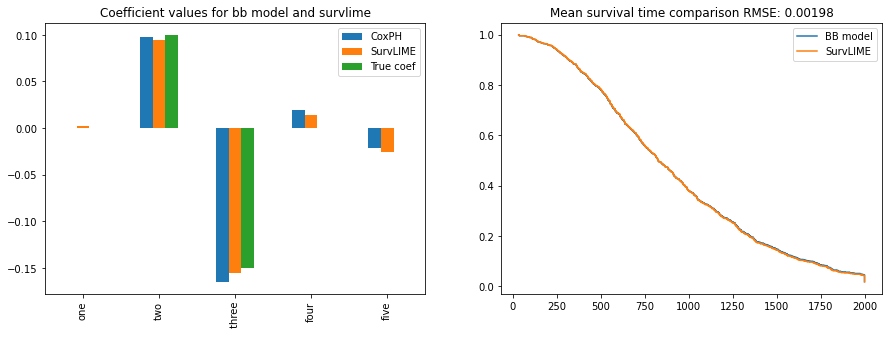

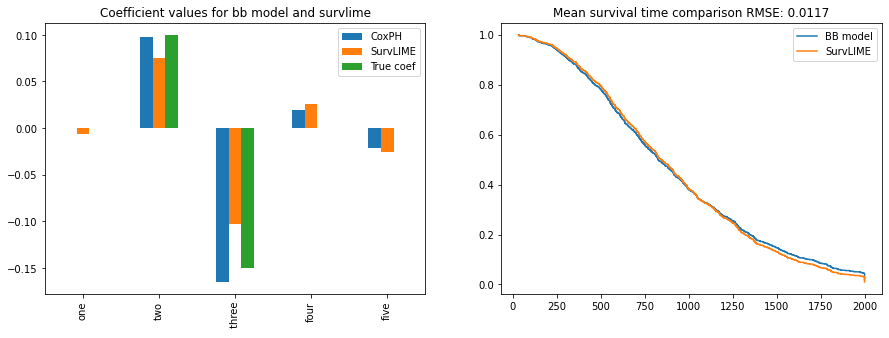

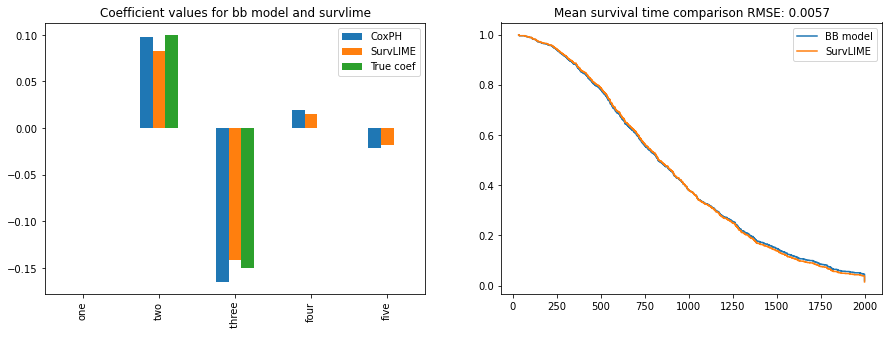

In [24]:

coefficients = [10**(-6), 0.1,  -0.15, 10**(-6), 10**(-6)]

model = CoxPHSurvivalAnalysis(alpha=0.0001)               
times_to_fill = list(set([x[1] for x in y_train_0])); times_to_fill.sort()
columns = ['one','two',' three', 'four', 'five']
model.fit(x_train_0, y_train_0)
model.feature_names_in_ = columns

compt_weights = pd.read_csv(w_path+f'exp_1.1_surv_weights_na.csv')

coef = model.coef_
dist = euclidean_distances(compt_weights, coef.reshape(1,-1))
closest = list(dist).index(min(dist))
furthest = list(dist).index(max(dist))

compare_survival_times(model, compt_weights.iloc[closest], x_train_0, y_train_0, x_test_0, true_coef=coefficients)
compare_survival_times(model, compt_weights.iloc[furthest], x_train_0, y_train_0, x_test_0, true_coef=coefficients)
compare_survival_times(model, compt_weights.mean(), x_train_0, y_train_0, x_test_0, true_coef=coefficients)

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


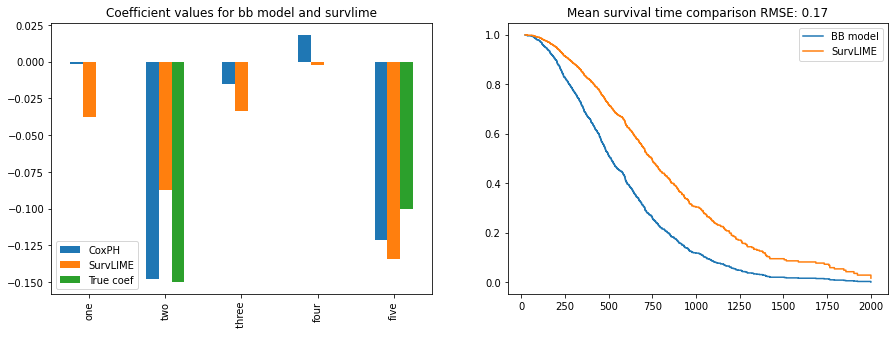

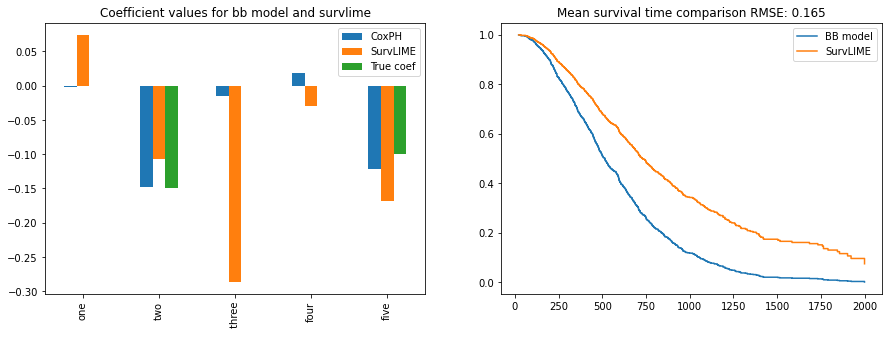

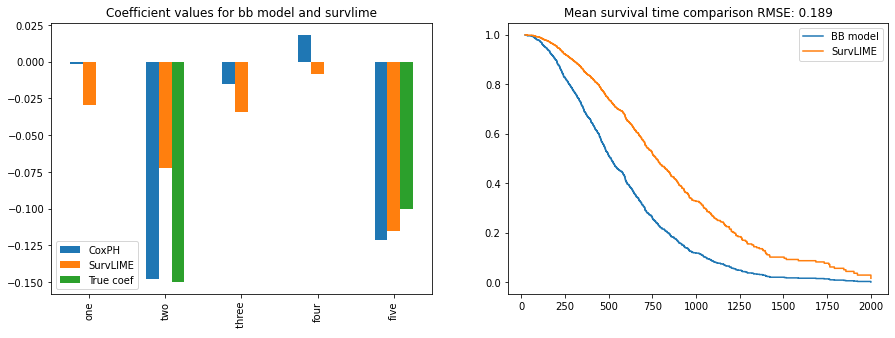

In [26]:
coefficients = [10**(-6), -0.15, 10**(-6), 10**(-6), -0.1]

model = CoxPHSurvivalAnalysis(alpha=0.0001)               
times_to_fill = list(set([x[1] for x in y_train_1])); times_to_fill.sort()
columns = ['one','two',' three', 'four', 'five']
model.fit(x_train_1, y_train_1)
model.feature_names_in_ = columns

compt_weights = pd.read_csv(w_path+f'exp_1.2_surv_weights_na.csv')

coef = model.coef_
dist = euclidean_distances(compt_weights, coef.reshape(1,-1))
closest = list(dist).index(min(dist))
furthest = list(dist).index(max(dist))

compare_survival_times(model, compt_weights.iloc[closest], x_train_1, y_train_1, x_test_1, true_coef=coefficients)
compare_survival_times(model, compt_weights.iloc[furthest], x_train_1, y_train_1, x_test_1, true_coef=coefficients)
compare_survival_times(model, compt_weights.mean(), x_train_1, y_train_1, x_test_1, true_coef=coefficients)

# Experiment 1.3
### Use cluster 0 and 1 for training and then use only cluster 0 or cluster 1 to obtain the weights

In [27]:
X_3 = np.concatenate([cluster_0[0], cluster_1[0]]); y_3 = np.concatenate([cluster_0[1], cluster_1[1]])
x_train, x_test, y_train, y_test = train_test_split(X_3, y_3, test_size=0.5, random_state=10)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=10)

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


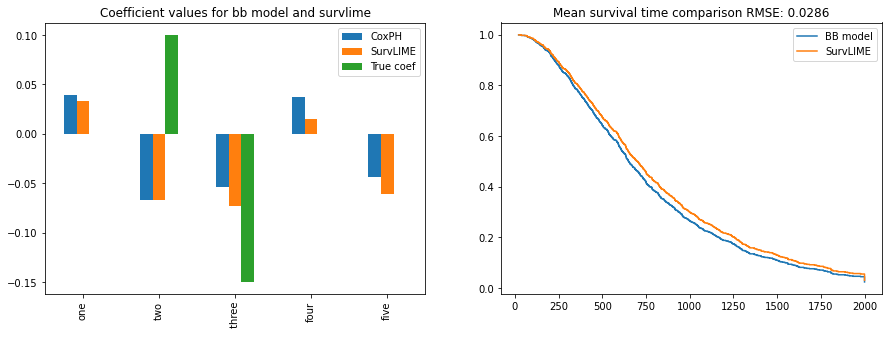

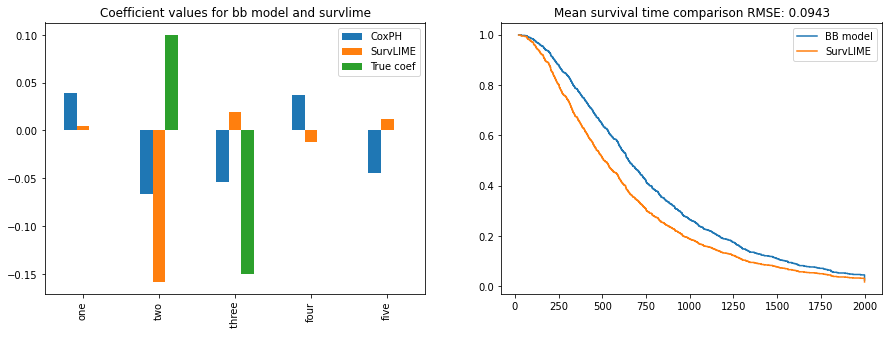

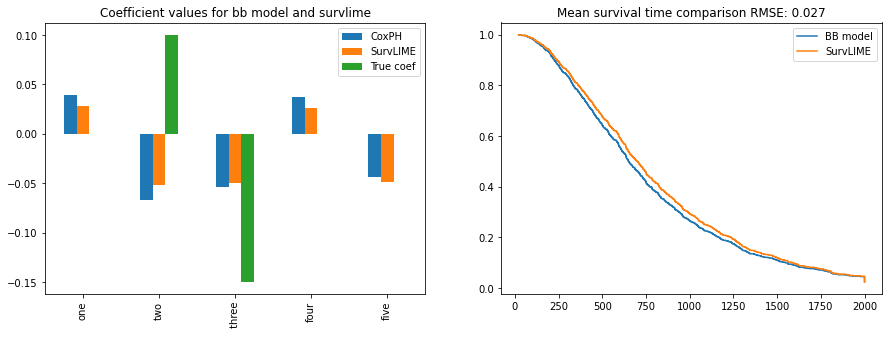

In [29]:
coefficients = [10**(-6), 0.1,  -0.15, 10**(-6), 10**(-6)]

model = CoxPHSurvivalAnalysis(alpha=0.0001)               
times_to_fill = list(set([x[1] for x in y_train])); times_to_fill.sort()
columns = ['one','two',' three', 'four', 'five']
model.fit(x_train, y_train)
model.feature_names_in_ = columns

compt_weights = pd.read_csv(w_path+f'exp_1.3_surv_weights_na.csv')

coef = model.coef_
dist = euclidean_distances(compt_weights, coef.reshape(1,-1))
closest = list(dist).index(min(dist))
furthest = list(dist).index(max(dist))

compare_survival_times(model, compt_weights.iloc[closest], x_train, y_train, x_test, true_coef=coefficients)
compare_survival_times(model, compt_weights.iloc[furthest], x_train, y_train, x_test, true_coef=coefficients)
compare_survival_times(model, compt_weights.mean(), x_train, y_train, x_test, true_coef=coefficients)

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


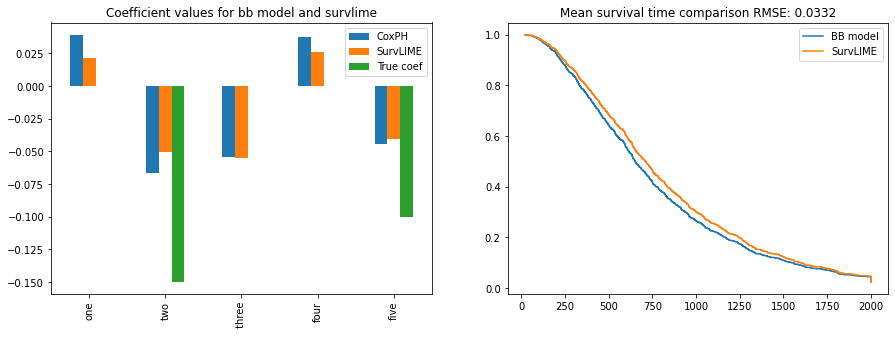

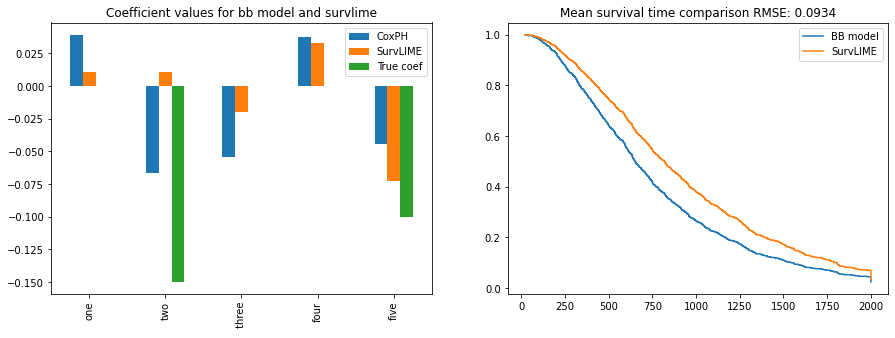

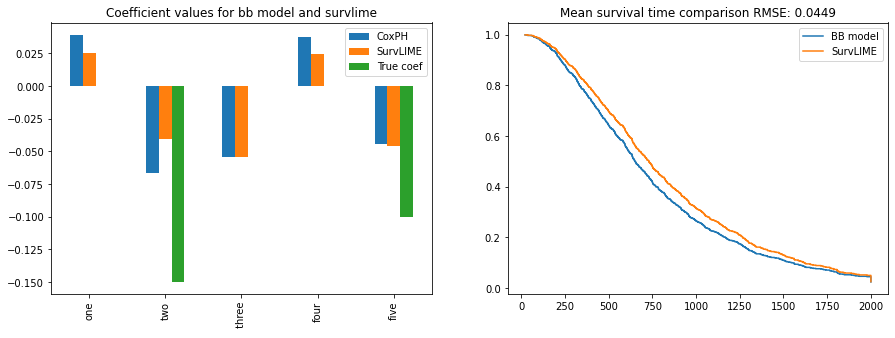

In [33]:
coefficients = [10**(-6), -0.15, 10**(-6), 10**(-6), -0.1]
compt_weights = pd.read_csv(w_path+f'exp_1.3.2_surv_weights_na.csv')

coef = model.coef_
dist = euclidean_distances(compt_weights, coef.reshape(1,-1))
closest = list(dist).index(min(dist))
furthest = list(dist).index(max(dist))

compare_survival_times(model, compt_weights.iloc[closest], x_train, y_train, x_test, true_coef=coefficients)
compare_survival_times(model, compt_weights.iloc[furthest], x_train, y_train, x_test, true_coef=coefficients)
compare_survival_times(model, compt_weights.mean(), x_train, y_train, x_test, true_coef=coefficients)

In [ ]:
import seaborn as sns
sns.set()
from tqdm import tqdm
from matplotlib.ticker import StrMethodFormatter


coefficients = [10**(-6), 0.1,  -0.15, 10**(-6), 10**(-6)]
coefficients = [10**(-6), -0.15, 10**(-6), 10**(-6), -0.1]
mean_dfs = []
max_dfs  = []
min_dfs  = []
exp = 2
surv_volume=np.ndarray((50,100,5))
for i in tqdm(range(50)):
    compt_weights = pd.read_csv(w_path+f'cox_exp_1.{exp}_rand_seed_{i}_surv_weights_na.csv')
    compt_weights = compt_weights.dropna(axis=0)
    compt_weights.columns = ['One', 'Two', 'Three', 'Four','Five']

    surv_volume[i] = compt_weights.to_numpy()
    dist = euclidean_distances(compt_weights, np.array(coefficients).reshape(1,-1))
    closest = list(dist).index(min(dist))
    furthest = list(dist).index(max(dist))
    
    mean_dfs.append(compt_weights.mean())
    max_dfs.append(compt_weights.iloc[furthest])
    min_dfs.append(compt_weights.iloc[closest])


import ipdb;ipdb.set_trace()
surv_volume = np.mean(surv_volume, axis=0)

dfs_together_mean= pd.concat(mean_dfs, axis=1).transpose()
dfs_together_min= pd.concat(min_dfs, axis=1).transpose()
dfs_together_max= pd.concat(max_dfs, axis=1).transpose()

dfs_together_max = dfs_together_max.reindex(dfs_together_max.median().sort_values(ascending=False).index, axis=1)
dfs_together_min = dfs_together_min.reindex(dfs_together_min.median().sort_values(ascending=False).index, axis=1)
dfs_together_mean = dfs_together_mean.reindex(dfs_together_mean.median().sort_values(ascending=False).index, axis=1)

fig, ax= plt.subplots(1,3, figsize=(20,5), sharey=True)
sns.boxenplot(x="variable", y="value", data=pd.melt(dfs_together_mean), ax=ax[0], palette='RdBu')
ax[0].set_title(f'Cluster {exp} mean values'); ax[0].tick_params(labelrotation=0); ax[0].xaxis.grid(True)
ax[0].set_ylabel('SurvLIME value')
ax[0].set_xlabel('Features')



sns.boxenplot(x="variable", y="value", data=pd.melt(dfs_together_min), ax=ax[1],palette='RdBu')
ax[1].set_title(f'Cluster {exp} best values'); ax[1].tick_params(labelrotation=0); ax[1].xaxis.grid(True)
ax[1].set_xlabel('Features')
ax[1].set_ylabel('SurvLIME value')



sns.boxenplot(x="variable", y="value", data=pd.melt(dfs_together_max), ax=ax[2],palette='RdBu')
ax[2].set_title(f'Cluster {exp} worst values'); ax[2].tick_params(labelrotation=0); ax[2].xaxis.grid(True)
ax[2].set_xlabel('Features')
ax[2].set_ylabel('SurvLIME value')

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

plt.savefig(f'figures/final_figures/exp_1.{exp}_results.png', bbox_inches = 'tight', dpi=200)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 293.24it/s]


--Return--
None
> /tmp/ipykernel_1882350/4137182428.py(34)<module>()
     33             print(i)
---> 34 import ipdb;ipdb.set_trace()
     35 



ipdb>  surv_volume.shape


(50, 100, 5)


In [ ]:
# Obsolete

# This will check whether the order of the values are the same. This ensures that the values don't have high variance
    if i!=0:
        if (compt_weights.iloc[furthest].sort_values(ascending=False).index == max_dfs[-1].sort_values(ascending=False).index).all():
            pass
        else:
            print(i)